In [ ]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import gdown
import torch
import tqdm
from keras import layers
from keras import ops
from zipfile import ZipFile

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [14]:
# os.makedirs("celeba_gan", exist_ok=True)

# url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
# output = "celeba_gan/data.zip"
# gdown.download(url, output, quiet=True)

# with zipfile.ZipFile(output, "r") as zipobj:
#     zipobj.extractall("celeba_gan")

Found 202599 files.


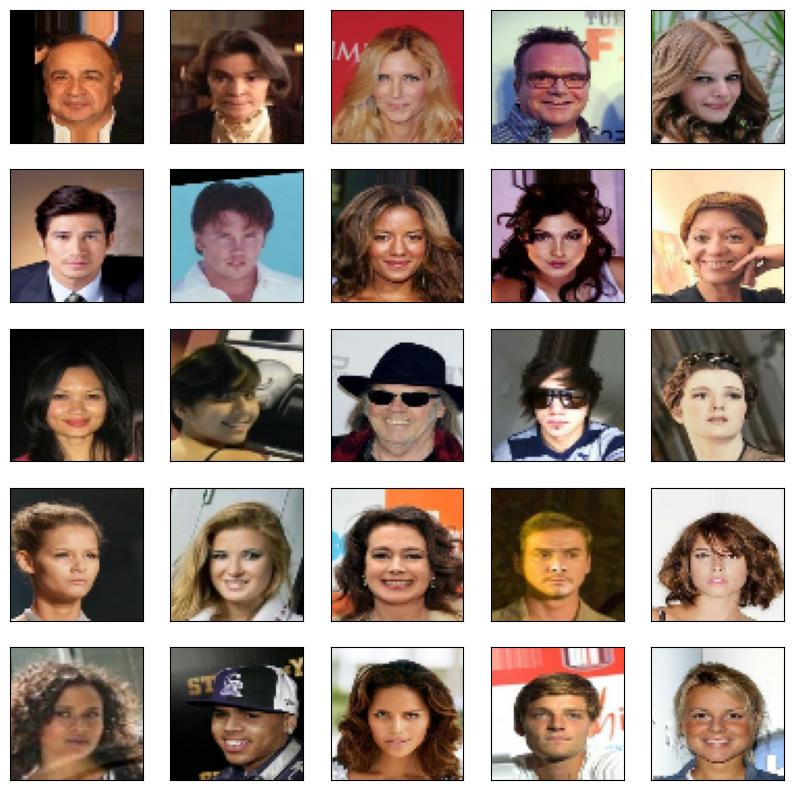

In [ ]:
dataset = keras.utils.image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), batch_size=16)
dataset = dataset.map(lambda x: (x / 127.5) - 1.0).shuffle(1000).prefetch(tf.data.AUTOTUNE)

plt.figure(figsize=(10, 10))
sample_images = list(dataset.unbatch().take(25).as_numpy_iterator())
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i])
plt.show()


In [16]:
latent_dim = 128

discriminator = keras.Sequential(
    [keras.Input(shape=(64, 64, 3)),
    
    layers.Conv2D(64, 4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),

    layers.Conv2D(128, 4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2D(256, 4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2D(512, 4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')],
    name="discriminator",
)
discriminator.summary()

generator = keras.Sequential(
    [keras.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 256),
    layers.Reshape((8, 8, 256)),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(256, 4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(64, 4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2D(3, 5, padding="same", activation="tanh")], 
    name="generator")
generator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 3)      │         4,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,825,539 (14.59 MB)

 Trainable params: 3,824,131 (14.59 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [17]:
discriminator.compile(loss ="binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss ="binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
)

In [18]:
def save_images(model, epoch, latent_dim, n=4):
    noise = tf.random.normal(shape =[n * n, latent_dim])
    generated_images = model(noise)
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(8, 8))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(generated_images[i])
    plt.savefig("generated_image_epoch_%d.png" % epoch)
    plt.close()

In [ ]:
def train_dcgan(epochs, dataset, batch_size, latent_dim):
    for epoch in tqdm.tqdm(range(epochs), desc="Epochs"):
        print(f"\nEpoch {epoch+1}/{epochs}")

        for x_batch in tqdm.tqdm(dataset, desc="Batches", leave=False):
            noise = tf.random.normal(shape=[batch_size, latent_dim])
            generated_images = generator(noise)

            x_batch = tf.cast(x_batch, generated_images.dtype)

            combined_images = tf.concat([generated_images, x_batch], axis=0)
            labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

            discriminator.trainable = True
            discriminator.train_on_batch(combined_images, labels)

            noise = tf.random.normal(shape=[batch_size, latent_dim])
            misleading_labels = tf.zeros((batch_size, 1))

            discriminator.trainable = False
            gan.train_on_batch(noise, misleading_labels)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            save_images(generator, epoch + 1, latent_dim)


In [ ]:
train_dcgan(epochs=50, dataset=dataset, batch_size=16, latent_dim=latent_dim)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


Epochs:   0%|          | 0/50 [00:09<?, ?it/s]/s]



KeyboardInterrupt: 